In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
pd.set_option('display.max_colwidth', 1000)

In [2]:
df = pd.DataFrame()
for i in range(5):
    file_name = 'data/data_' + str(i) + '.csv'
    df_data = pd.read_csv(file_name)
    df = df.append(df_data)
df = df.reset_index(drop=True)

In [3]:
def remove_terms(tweet, keyword, character):
    if keyword:
        for i in keyword:       
            tweet = tweet.replace(character+i.lower(),'')
    return tweet

In [4]:
# Removing some columns about user information
df = df.drop(columns=['date','link','hour','username','name_x','retweet','location','verified','private','avatar','background_image'])

# 'tweets' column to lowercase
df['tweet'] = df['tweet'].str.lower()

# Transform the data type of some columns
df['label'] = df['label'].astype(int)

# Transform object type to list
df['hashtags'] = df['hashtags'].apply(lambda x: x.strip('][').split(', ') if x != '[]' else 0)
df['hashtags'] = df['hashtags'].apply(lambda x:[item.strip("'") for item in x] if x != 0 else 0)
screen_name = re.compile("screen_name': '(\w+)'")
df['reply_to'] = df['reply_to'].apply(lambda x:screen_name.findall(x))

# Remove hashtags and reply_to from tweet
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['hashtags'],'#'), axis=1)
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['reply_to'],'@'), axis=1)

# Add a column about 'mention'
screen_name = re.compile("@(\w+)")
df['mention'] = df['tweet'].apply(lambda x:screen_name.findall(x))

# Remove mention from tweet
df['tweet'] = df.apply(lambda row:remove_terms(row['tweet'],row['mention'],'@'), axis=1)

# Transform 'reply_to' and 'mention' to int
df['reply_to'] = df['reply_to'].apply(lambda x:len(x) if x != '[]' else 0)
df['mention'] = df['mention'].apply(lambda x:len(x) if x != '[]' else 0)

# Remove photos and video link from tweet
df['tweet'] = df['tweet'].apply(lambda x:re.sub('https://[a-z./0-9]+', '', x))
df['tweet'] = df['tweet'].str.strip()

# Add a column about tweet length
df['tweet_length'] = df['tweet'].apply(lambda x:len(x.split()))

# quote_url is when people quote other's tweets in their tweets.
# Assuming that people quote others tweet is for commenting, not tend to have suicidality
df['quote_url'] = df['quote_url'].astype(str)
df['quote_url'] = df['quote_url'].apply(lambda x: 0 if x=="0" or x=='nan' else 1)

# 'Bio' has NaN value
df['bio'] = df['bio'].replace('\n',' ',regex=True)
df['bio'] = df['bio'].replace('\r',' ',regex=True)

# urls,photos will be classified as 0 or 1
df['urls'] = df['urls'].apply(lambda x: 0 if x == "[]" else 1)
df['photos'] = df['photos'].apply(lambda x: 0 if x == "[]" else 1)

# 'url' is when people put some link on their user profile
df['url'] = df['url'].astype(str)
df['url'] = df['url'].apply(lambda x: 0 if x == 'nan' else 1)

# Concatenate the sentimental analysis
# 0 = negative, 2 = neutral, 4 = positive
df_data = pd.read_csv('data/tweets_sentiment_result.csv')
df_data.columns = ['tweet_sentiment','tweet']
df['tweet_sentiment'] = df_data['tweet_sentiment']

df_data = pd.read_csv('data/bio_sentiment_result.csv')
df_data.columns = ['bio_sentiment','bio']
df['bio_sentiment'] = df_data['bio_sentiment']

# Drop 'bio'
df = df.drop(columns=['bio'])

# change the join_time to '#years user registered a twitter account'
df['join_time'] = 2021 - pd.DatetimeIndex(pd.to_datetime(df['join_date'])).year

df = df.drop(columns=['join_date'])

In [5]:
# investigating 'hashtags'
lst = []
for element in df['hashtags']:
    if element != 0:
        lst += element
hashtags = pd.DataFrame(lst)
hashtags.value_counts().head(5)

mentalhealth                  59
suicidal                      54
depression                    34
suicideprevention             33
turkishstudentslivesmatter    29
dtype: int64

For tweets having suicidal label,  97% of them don't have hashtags.  
We can assume usually people want to raise awareness about suicide may put hashtags.  
Therefore it would be safe to only put numbers of hashtags as feature.  

In [6]:
df['hashtags'] = df['hashtags'].apply(lambda x:len(x) if x != 0 else 0)

#### The pronouns of a tweet
When a tweet is using first-person point of view, it's more likely to refer to the tweet owner's personal feeling, therefore, more likely to be real suicidal thoughts.  
Whereas tweets in second/third person point of view are more like people describing other events.  

In [7]:
first_person = ['i', 'my', 'me', 'am']
df['first_person'] = 0
for word in first_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    first_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['first_person'] = df['first_person'] | first_person_lst
    
second_person = ['you', 'your', 'yours']
df['second_person'] = 0
for word in second_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    second_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['second_person'] = df['second_person'] | second_person_lst
    
third_person = ['he','she',"he's","she's", 'his','her','him','they','them']
df['third_person'] = 0
for word in third_person:
    word_ = re.compile('(^|\s)' + word + '($|\s)')
    third_person_lst = df['tweet'].apply(lambda x:1 if len(word_.findall(x)) > 0 else 0)
    df['third_person'] = df['third_person'] | third_person_lst

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11439 entries, 0 to 11438
Data columns (total 26 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            11439 non-null  object
 1   label            11439 non-null  int32 
 2   hashtags         11439 non-null  int64 
 3   day              11439 non-null  int64 
 4   urls             11439 non-null  int64 
 5   photos           11439 non-null  int64 
 6   video            11439 non-null  int64 
 7   nlikes           11439 non-null  int64 
 8   nreplies         11439 non-null  int64 
 9   nretweets        11439 non-null  int64 
 10  quote_url        11439 non-null  int64 
 11  reply_to         11439 non-null  int64 
 12  url              11439 non-null  int64 
 13  join_time        11439 non-null  int64 
 14  tweets           11439 non-null  int64 
 15  following        11439 non-null  int64 
 16  followers        11439 non-null  int64 
 17  likes            11439 non-null

### Feature Engineering

<AxesSubplot:xlabel='mention'>

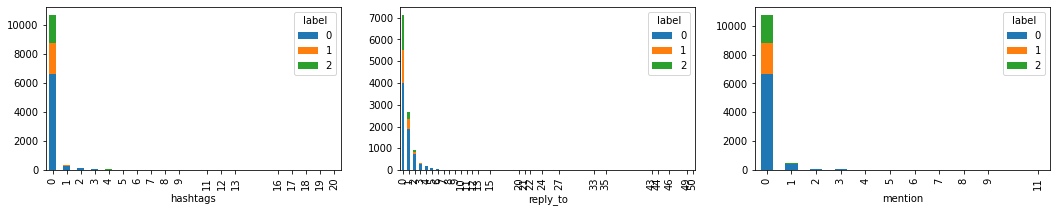

In [9]:
fig, axs = plt.subplots(ncols=3,figsize=(18,3))
df.groupby(['hashtags','label'])['hashtags'].count().unstack().plot(kind='bar',stacked=True,ax=axs[0])
df.groupby(['reply_to','label'])['reply_to'].count().unstack().plot(kind='bar',stacked=True,ax=axs[1])
df.groupby(['mention','label'])['mention'].count().unstack().plot(kind='bar',stacked=True,ax=axs[2])

Since most of the 'hashtags' and 'mention' are empty, we don't they are good features.

<AxesSubplot:xlabel='quote_url'>

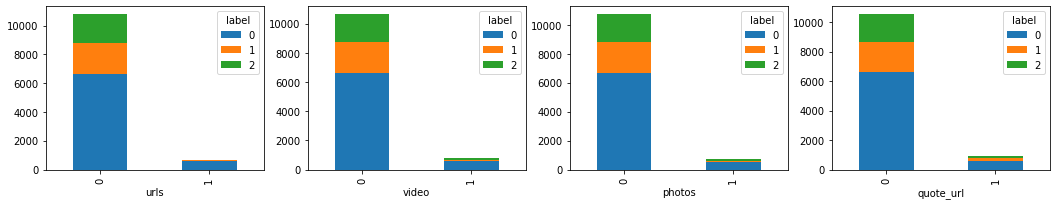

In [10]:
fig, axs = plt.subplots(ncols=4,figsize=(18,3))
df.groupby(['urls','label'])['urls'].count().unstack().plot(kind='bar',stacked=True,ax=axs[0])
df.groupby(['video','label'])['video'].count().unstack().plot(kind='bar',stacked=True,ax=axs[1])
df.groupby(['photos','label'])['photos'].count().unstack().plot(kind='bar',stacked=True,ax=axs[2])
df.groupby(['quote_url','label'])['quote_url'].count().unstack().plot(kind='bar',stacked=True,ax=axs[3])

Seems like most of the media are empty. We could safely drop them.

<AxesSubplot:title={'center':'Not Suicidal People by day'}>

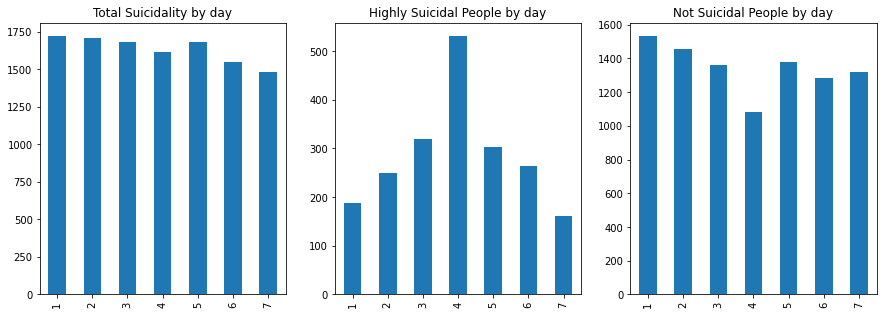

In [11]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Total Suicidality by day')
df['day'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,3,2)
plt.title('Highly Suicidal People by day')
df[df['label'] == 2]['day'].value_counts().sort_index().plot(kind='bar')
plt.subplot(1,3,3)
plt.title('Not Suicidal People by day')
df[df['label'] != 2]['day'].value_counts().sort_index().plot(kind='bar')

Interesting, how come on Thursday suicidal vibe is so strong?  
We can use the absolute value to map this tendency.  

In [12]:
df = df.drop(columns=['hashtags','mention','quote_url','urls','photos','video'])

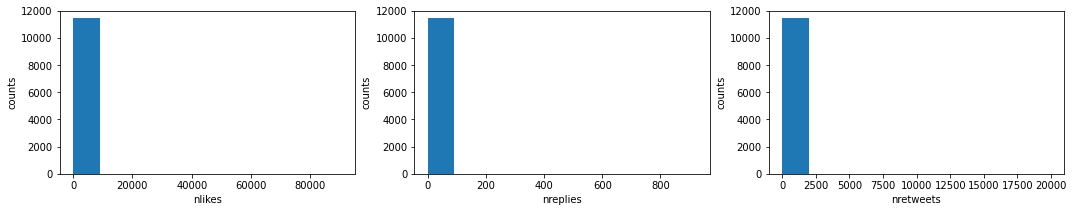

In [13]:
plt.figure(figsize=(18,3))
lst = ['nlikes', 'nreplies', 'nretweets']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(df[lst[i]],bins=10);
    plt.xlabel(lst[i])
    plt.ylabel('counts')

There are some tweets received many likes and replies.  
Those are really outliers, so we apply log to them.

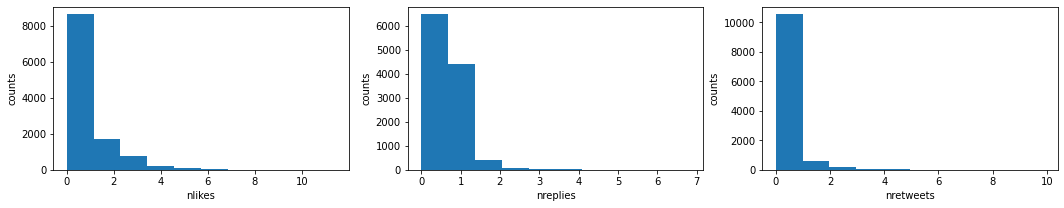

In [14]:
plt.figure(figsize=(18,3))
lst = ['nlikes', 'nreplies', 'nretweets']
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(np.log1p(df[lst[i]]),bins=10);
    plt.xlabel(lst[i])
    plt.ylabel('counts')

They are still extremely skewed.

Apply the same for other numeric features.

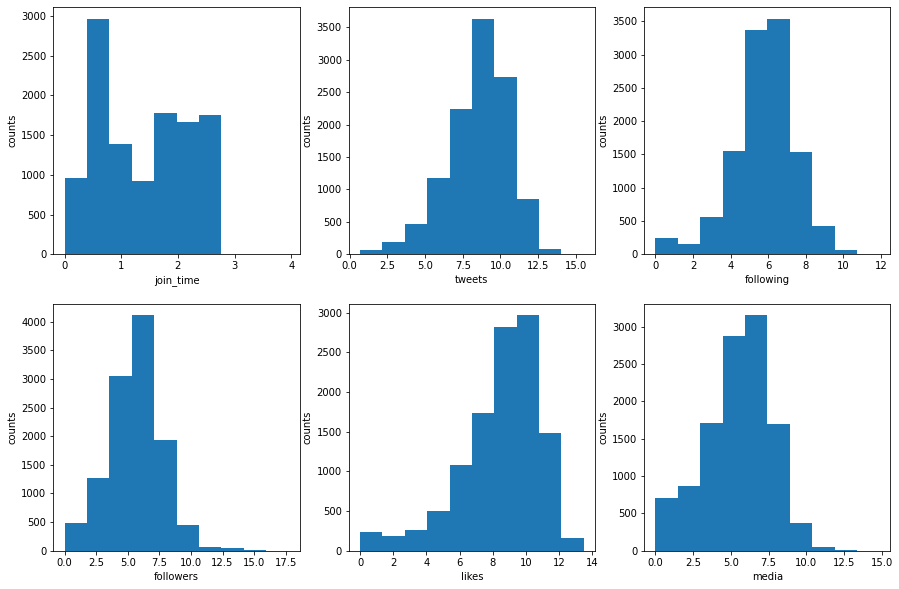

In [15]:
plt.figure(figsize=(15,10))
lst = ['join_time', 'tweets', 'following', 'followers', 'likes', 'media']
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.hist(np.log1p(df[lst[i]]),bins=10);
    plt.xlabel(lst[i])
    plt.ylabel('counts')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11439 entries, 0 to 11438
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   tweet            11439 non-null  object
 1   label            11439 non-null  int32 
 2   day              11439 non-null  int64 
 3   nlikes           11439 non-null  int64 
 4   nreplies         11439 non-null  int64 
 5   nretweets        11439 non-null  int64 
 6   reply_to         11439 non-null  int64 
 7   url              11439 non-null  int64 
 8   join_time        11439 non-null  int64 
 9   tweets           11439 non-null  int64 
 10  following        11439 non-null  int64 
 11  followers        11439 non-null  int64 
 12  likes            11439 non-null  int64 
 13  media            11439 non-null  int64 
 14  tweet_length     11439 non-null  int64 
 15  tweet_sentiment  11439 non-null  int64 
 16  bio_sentiment    11439 non-null  int64 
 17  first_person     11439 non-null

### Data Preprocessing

###### tf-count and topic model for tweets

In [17]:
# # The lemmatization does not work really well.
# import nltk
# nltk.download('wordnet')
# from nltk.stem.wordnet import WordNetLemmatizer
# df['tweet'] = df['tweet'].apply(lambda x:' '.join(WordNetLemmatizer().lemmatize(i) for i in x.split(' ')))

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Adding a list of stop words to the wordlist
my_stop_words = text.ENGLISH_STOP_WORDS.union(['suicidal','bc','did','didn','t','does','doesn','don','dont','doing','going','gonna','having','isn','ll','ve','wanna','want','wanted','wanting','wasn','went','yes','yeah'])
count_vectorizer = CountVectorizer(min_df=0.01, stop_words=my_stop_words)
x = count_vectorizer.fit_transform(df['tweet'])

n,m = x.shape
k = 20 # try for 20 topics
lda = LatentDirichletAllocation(n_components=k, random_state=2021)
xtr = lda.fit_transform(x)

# So xtr will be new features to replace 'tweet'
data_x = pd.DataFrame(xtr).add_prefix('topic_')

#### Take log for some features.

In [18]:
features_to_log = ['nlikes', 'nreplies', 'nretweets','join_time', 'tweets', 'following', 'followers', 'likes', 'media']
for feature in features_to_log:
    data_x[feature] = np.log1p(df[feature])

'day' take absolute values, tweet_length take min-max scale.

In [19]:
df['day'] = (df['day'] - 4).abs()
df['tweet_length'] = df['tweet_length'] / df['tweet_length'].max()

In [20]:
features_to_add = ['day','url','tweet_length', 'tweet_sentiment', 'bio_sentiment', 'first_person', 'second_person', 'third_person']
for feature in features_to_add:
    data_x[feature] = df[feature]

In [21]:
data_y = df['label']

### Modelling

In [22]:
from sklearn import model_selection
x_train, x_test, y_train, y_test = model_selection.train_test_split(data_x, data_y, test_size = 0.2, random_state = 2021)

In [23]:
from sklearn import linear_model, metrics
estimator = linear_model.LogisticRegression(class_weight='balanced',
                                            multi_class='ovr',
                                            C=0.01,
                                            max_iter=1000)

estimator.fit(x_train, y_train)
y_pred = estimator.predict(x_test)
report = """
The evaluation report of OVR is:
Confusion Matrix:
{}
Accuracy: {}
""".format(metrics.confusion_matrix(y_test, y_pred),
           metrics.accuracy_score(y_test, y_pred))
print(report)


The evaluation report of OVR is:
Confusion Matrix:
[[1022  181  254]
 [ 157  102  164]
 [  86   66  256]]
Accuracy: 0.6031468531468531



#### Reference: Sentiment analysis through Sentiment140 API

In [ ]:
# Save 'tweet' and 'bio' for sentiment analysis
df['tweet'].to_csv('data/tweets_for_sentiment.txt',index=False)
df['bio'].to_csv('data/bio_for_sentiment.txt',index=False)

In [46]:
! curl --data-binary @tweets_for_sentiment.txt "http://www.sentiment140.com/api/bulkClassify?appid=feixie.2020@mitb.smu.edu.sg" > tweets_sentiment_result.csv
! curl --data-binary @bio_for_sentiment.txt "http://www.sentiment140.com/api/bulkClassify?appid=feixie.2020@mitb.smu.edu.sg" > bio_sentiment_result.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  355k    0     0  100  355k      0  3669k --:--:-- --:--:-- --:--:-- 3632k
100  355k    0     0  100  355k      0   292k  0:00:01  0:00:01 --:--:--  292k
100  355k    0     0  100  355k      0   160k  0:00:02  0:00:02 --:--:--  160k
 56  725k   13 52608  100  355k  16888   114k  0:00:22  0:00:03  0:00:19  130k
100  725k  100  369k  100  355k    98k  97079  0:00:03  0:00:03 --:--:--  193k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  184k    0     0  100  184k      0   150k  0:00:01  0:00:01 --:--:--  150k
 51  381k    6 13463  100  184k   8504   116k  0:0